<div><span style="background-color: #9e4244; padding-top: 80px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: white; font-size: 22px; font-weight: bold">AutoML 2</span></div>

In [68]:
# General Libraries
import re
import time
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
warnings.filterwarnings("ignore")

# Visualizations
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     StratifiedKFold)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,  
                              GradientBoostingClassifier)
from sklearn.model_selection import cross_validate
from sklearn.metrics import (ConfusionMatrixDisplay, precision_score, recall_score,f1_score, accuracy_score)

# Imblearn
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import (SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE)
from imblearn.under_sampling import (TomekLinks, NearMiss, AllKNN,
                                     EditedNearestNeighbours, 
                                     RepeatedEditedNearestNeighbours) 
from imblearn.combine import SMOTETomek, SMOTEENN
import sklearn.metrics as metrics

#from getml.predictors import XGBoostClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb
# SHAP
# interpretability
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer
import pickle
import catboost as ctb

shap.initjs()
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime
#%unload_ext autotime


The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 16 ms (started: 2022-11-30 19:58:50 +08:00)


# Load Data

In [186]:

#df= pickle.load(open('data/ml_dataset_v8.pkl', "rb"))
df= pickle.load(open('data/!ml_dataset_hotel_level_v2.pkl', "rb"))
#df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


X = df.drop(['is_good_stay'], axis=1)
y = df['is_good_stay']
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                                                   test_size=0.25,
                                                                  stratify=y)

df.shape

(307, 462)

time: 0 ns (started: 2022-11-30 21:45:40 +08:00)


In [187]:
df.columns.value_counts()

average_price    1
ticket           1
themed           1
terrace          1
tennis           1
                ..
garage           1
game             1
gallery          1
furniture        1
city_Taguig      1
Length: 462, dtype: int64

time: 0 ns (started: 2022-11-30 21:46:09 +08:00)


<div><span style="background-color: #ff0257; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFAF0; font-size: 18px; font-weight: bold">Auto-ML </span></div>

In [188]:
def auto_ml(X, y, models_dict, scaler=None, cv=None, res_t=None):
    """Apply resampling for imbalanced data"""
    results = {}
    results2 = {}

    # log start time
    total_start = time.time()

    for model_name, model in tqdm(models_dict.items()):
        
        ################# this portion can be edited ###############
        train_scores = []
        val_scores = []

        train_precision = []
        val_precision = []
        val_prec_stdev=[]
        
        train_recall = []
        val_recall = []
        val_recall_stdev=[]
        
        train_f1 = []
        val_f1 = []
        val_f1_stdev=[]

        ###########################################################

        for train_index, val_index in tqdm(cv.split(X, y)):

            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # Apply scaling
            if scaler is not None:
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
            else:
                pass

            # Apply resampling
            if res_t is not None:
                s = time.time()
                X_train, y_train = res_t.fit_resample(X_train, y_train)
                print(f'Resampling done in {time.time() - s}')
            else:
                pass

            start_time = time.time()

            # fit
            model.fit(X_train, y_train)

            # predict
            train_preds = model.predict(X_train)
            val_preds = model.predict(X_val)
            
            ################# this portion can be edited ###############

            # classification accuracy
            train_scores.append(model.score(X_train, y_train))
            val_scores.append(model.score(X_val, y_val))

            # precision
            train_precision.append(precision_score(y_train, train_preds))
            val_precision.append(precision_score(y_val, val_preds))
            
            # recall
            train_recall.append(recall_score(y_train, train_preds))
            val_recall.append(recall_score(y_val, val_preds))
            
            # f1
            train_f1.append(f1_score(y_train, train_preds))
            val_f1.append(f1_score(y_val, val_preds))

            end_time = time.time()

            results[model_name] = {
                'Train Accuracy': np.round(np.mean(train_scores) * 100, 2),
                'Val Accuracy': np.round(np.mean(val_scores) * 100, 2),
                'Train Precision': np.round(np.mean(train_precision) * 100, 2),
                'Val Precision': np.round(np.mean(val_precision) * 100, 2),
                'Val P.Std': np.round(np.std(val_precision) * 100, 2),
                'Val Recall': np.round(np.mean(val_recall) * 100, 2),
                'Val R.Std': np.round(np.std(val_recall) * 100, 2),
                'Val F1': np.round(np.mean(val_recall) * 100, 2),
                'Val F1.Std': np.round(np.std(val_recall) * 100, 2),
                
                'Run Time': end_time - start_time
            }

            results2[model_name] = {
                'Train Accuracy': '{:.2f}%'.format(np.round(np.mean(train_scores)*100, 2)),
                'Val Accuracy': '{:.2f}%'.format(np.round(np.mean(val_scores)*100, 2)),
                'Train Precision': '{:.2f}%'.format(np.round(np.mean(train_precision)*100, 2)),
                'Val Precision': '{:.2f}%'.format(np.round(np.mean(val_precision)*100, 2)),
                'Val P.Std': '{:.2f}%'.format(np.round(np.std(val_precision)*100, 2)),
                'Val Recall': '{:.2f}%'.format(np.round(np.mean(val_recall)*100, 2)),
                'Val R.Std': '{:.2f}%'.format(np.round(np.std(val_recall)*100, 2)),
                'Val F1': '{:.2f}%'.format(np.round(np.mean(val_f1)*100, 2)),
                'Val F1.Std': '{:.2f}%'.format(np.round(np.std(val_f1)*100, 2)),
                'Run Time': end_time - start_time
            }
            
            ###########################################################

    results = pd.DataFrame(results).T
    results2 = pd.DataFrame(results2).T
    return [results, results2,model]


#-----------------------------------------------------------------------

def plot_scores(cv_scores_mean,cv_scores_std,metric):
    fig,axs = plt.subplots(1,2, figsize=(11,4))
    
    x = np.arange(len(cv_scores_mean))
    max_mean_score_idx = cv_scores_mean.argmax()
    
    axs[0].plot(x, cv_scores_mean, marker='.', lw=0)
    axs[0].plot(x[max_mean_score_idx],max(cv_scores_mean), marker="o", ms=7, color='r')
    axs[0].set_xlabel("Model config type")
    axs[0].set_ylabel("metric")

    axs[1].plot(x, cv_scores_std, marker='.', lw=0)
    axs[1].plot(x[max_mean_score_idx],cv_scores_std[max_mean_score_idx], marker="o", ms=7, color='r')
    axs[1].set_xlabel("Model config type")
    axs[1].set_ylabel(metric + " standard deviation")


def gridsearch(model,parameters,metric):
    Grid_model = GridSearchCV(estimator=model, param_grid = parameters, scoring=metric, cv = 5, n_jobs=-1,verbose=10)
    Grid_model.fit(X_trainval, y_trainval)


    #get scores
    cv_scores_mean =  Grid_model.cv_results_['mean_test_score']
    cv_scores_std = Grid_model.cv_results_['std_test_score']
    max_mean_score_idx = cv_scores_mean.argmax()

    print("")
    print("Best Estimator: {}".format(Grid_model.best_estimator_))
    print("Best Parameters: {}".format(Grid_model.best_params_))
    print('Best model CV config score is %f%% (vs. overall mean score: %f )' % (100*cv_scores_mean[max_mean_score_idx],
                                                                            100*np.mean(cv_scores_mean)))
    print('Std of best model score across folds is %f (vs. overall mean std: %f )' %\
          (cv_scores_std[max_mean_score_idx], np.mean(cv_scores_std)))

    # get best model
    model1 = Grid_model.best_estimator_
    # fit model for entire data
    model1.fit(X, y)
    pred1 = model1.predict(X)


    if metric=="accuracy":
        score = accuracy_score(y, pred1) * 100
    if metric=="recall":
        score = recall_score(y, pred1) * 100
    if metric=="precision":
        score = precision_score(y, pred1) * 100
    if metric=="f1":
        score = f1_score(y, pred1) * 100


    print('The %s of model for the full dataset is %f%%' % (metric,score))
    print('DONE!')
    
    print(" ")
    
    #print("Best Parameters: \n{}\n".format(Grid_model.best_params_))
    #print("Best Test Score: \n{}\n".format(Grid_model.best_score_))
    
    plot_scores(cv_scores_mean,cv_scores_std,metric)


time: 0 ns (started: 2022-11-30 21:46:10 +08:00)


### Baseline

In [191]:

    
    
models_dict = {
    'XGBoostClassifier': xgb.XGBClassifier(n_jobs=-1,tree_method="gpu_hist"),
    'KNeighborsClassifier': KNeighborsClassifier(n_jobs=-1),
    'LogisticRegressor': LogisticRegression(n_jobs=-1),
    #'GaussianNB': GaussianNB(),
    'RandomForestClassifier': RandomForestClassifier(n_jobs=-1),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    #'GradientBoostingClassifier': GradientBoostingClassifier(),
    'LGBMClassifier':LGBMClassifier(n_jobs=-1),
    'CatBoostClassifier':ctb.CatBoostClassifier(#task_type="GPU",
                                                thread_count=-1,logging_level='Silent')
    
}




time: 15 ms (started: 2022-11-30 21:46:23 +08:00)


In [192]:
auto_run = auto_ml(X_trainval, y_trainval, models_dict, scaler=MinMaxScaler(),
               cv=StratifiedKFold(n_splits=5))
auto = auto_run[0]
auto_run[1]

  0%|          | 0/7 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,Train Accuracy,Val Accuracy,Train Precision,Val Precision,Val P.Std,Val Recall,Val R.Std,Val F1,Val F1.Std,Run Time
XGBoostClassifier,100.00%,66.52%,100.00%,70.25%,8.72%,73.59%,7.49%,71.82%,7.92%,0.343489
KNeighborsClassifier,81.85%,69.57%,82.43%,73.25%,6.45%,74.36%,11.34%,73.48%,8.07%,0.030918
LogisticRegressor,95.98%,66.52%,96.99%,69.17%,6.02%,76.67%,8.03%,72.52%,5.84%,0.363997
RandomForestClassifier,100.00%,69.13%,100.00%,70.68%,7.05%,78.80%,10.33%,74.47%,8.36%,0.184074
DecisionTreeClassifier,100.00%,62.61%,100.00%,68.37%,9.11%,66.01%,8.56%,67.03%,8.30%,0.011028
LGBMClassifier,100.00%,66.09%,100.00%,70.87%,7.07%,71.37%,5.38%,70.90%,4.75%,0.05797
CatBoostClassifier,99.02%,70.87%,99.81%,71.49%,6.09%,82.62%,6.74%,76.60%,6.09%,6.131667


time: 38.3 s (started: 2022-11-30 21:46:25 +08:00)


### Applying resampling techniques

#### Oversampling

In [92]:
res_list = [('SMOTE', SMOTE()),
            ('ADASYN', ADASYN())]

outputs = []
for title, res in res_list:
    print(colored(title, 'red', attrs=['bold']).center(120, "-"))
    var = auto_ml(X_trainval, y_trainval, models_dict, scaler=MinMaxScaler(),
                    cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs.append(var[0])
    display(var[1])

---------------------------------------------------SMOTE---------------------------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.0039899349212646484
Resampling done in 0.003989696502685547
Resampling done in 0.00399017333984375
Resampling done in 0.0039899349212646484
Resampling done in 0.003988981246948242


0it [00:00, ?it/s]

Resampling done in 0.003989458084106445
Resampling done in 0.004987001419067383
Resampling done in 0.004985809326171875
Resampling done in 0.00498652458190918
Resampling done in 0.0050487518310546875


0it [00:00, ?it/s]

Resampling done in 0.005985736846923828
Resampling done in 0.004987239837646484
Resampling done in 0.004987478256225586
Resampling done in 0.003989696502685547
Resampling done in 0.003990650177001953


0it [00:00, ?it/s]

Resampling done in 0.004987001419067383
Resampling done in 0.004987001419067383
Resampling done in 0.004987239837646484
Resampling done in 0.00498652458190918
Resampling done in 0.005983829498291016


0it [00:00, ?it/s]

Resampling done in 0.004987478256225586
Resampling done in 0.004988670349121094
Resampling done in 0.004088640213012695
Resampling done in 0.00498652458190918
Resampling done in 0.00498652458190918


0it [00:00, ?it/s]

Resampling done in 0.005984783172607422
Resampling done in 0.004987001419067383
Resampling done in 0.003988981246948242
Resampling done in 0.004060506820678711
Resampling done in 0.00498652458190918


0it [00:00, ?it/s]

Resampling done in 0.004987239837646484


KeyboardInterrupt: 

time: 6.53 s (started: 2022-11-30 20:03:04 +08:00)


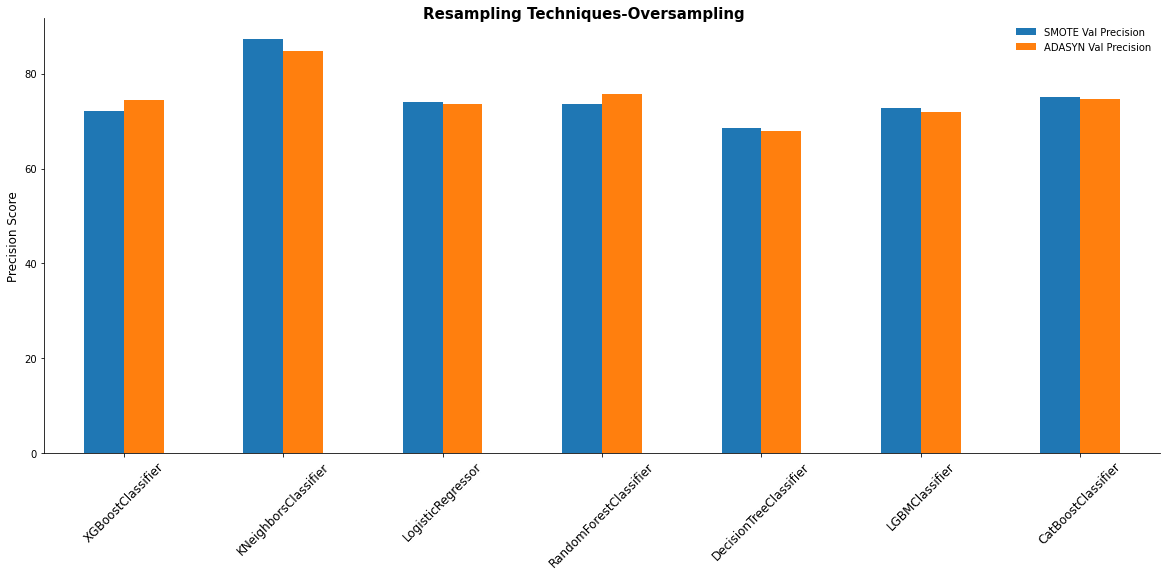

time: 266 ms (started: 2022-11-30 19:28:55 +08:00)


In [37]:
ps_over = pd.DataFrame(index=models_dict.keys())
ps_over['NoResampling Val Precision'] = auto_run[1]['Val Precision']
ps_over['SMOTE Val Precision'] = outputs[0]['Val Precision']
ps_over['ADASYN Val Precision'] = outputs[1]['Val Precision']
fig, ax = plt.subplots(figsize=(20, 8))
ps_over.plot.bar(ax=ax)
ax.set_ylabel('Precision Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Oversampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

#### Undersampling

In [38]:
res_list = [('TomekLinks', TomekLinks()),
            ('NearMiss', NearMiss())]

outputs_u = []
for title, res in res_list:
    print(colored(title, 'red', attrs=['bold']).center(120, "-"))
    var = auto_ml(X_trainval, y_trainval, models_dict, scaler=MinMaxScaler(),
                  cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs_u.append(var[0])
    display(var[1])

------------------------------------------------TomekLinks-------------------------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.007978439331054688
Resampling done in 0.003989458084106445
Resampling done in 0.0049860477447509766
Resampling done in 0.0039899349212646484
Resampling done in 0.004987478256225586


0it [00:00, ?it/s]

Resampling done in 0.004987001419067383
Resampling done in 0.004987478256225586
Resampling done in 0.005984306335449219
Resampling done in 0.005984306335449219
Resampling done in 0.004986763000488281


0it [00:00, ?it/s]

Resampling done in 0.005984306335449219
Resampling done in 0.00498652458190918
Resampling done in 0.005983114242553711
Resampling done in 0.004987001419067383
Resampling done in 0.00498652458190918


0it [00:00, ?it/s]

Resampling done in 0.0059833526611328125
Resampling done in 0.004987001419067383
Resampling done in 0.004987001419067383
Resampling done in 0.005984306335449219
Resampling done in 0.00598454475402832


0it [00:00, ?it/s]

Resampling done in 0.0069811344146728516
Resampling done in 0.004986763000488281
Resampling done in 0.005983591079711914
Resampling done in 0.0049877166748046875
Resampling done in 0.005078554153442383


0it [00:00, ?it/s]

Resampling done in 0.005984067916870117
Resampling done in 0.004987239837646484
Resampling done in 0.005985260009765625
Resampling done in 0.0059850215911865234
Resampling done in 0.005983829498291016


0it [00:00, ?it/s]

Resampling done in 0.004987239837646484
Resampling done in 0.0050737857818603516
Resampling done in 0.0059850215911865234
Resampling done in 0.0049896240234375
Resampling done in 0.005984067916870117


,Train Accuracy,Val Accuracy,Train Precision,Val Precision,Val P.Std,Val Recall,Val R.Std,Val F1,Val F1.Std,Run Time
XGBoostClassifier,100.00%,69.57%,100.00%,73.06%,5.50%,75.98%,4.84%,74.30%,3.59%,0.351313
KNeighborsClassifier,81.51%,67.39%,86.91%,80.92%,11.18%,60.20%,8.88%,67.93%,4.26%,0.032912
LogisticRegressor,98.08%,66.96%,98.98%,71.90%,6.11%,71.48%,7.81%,71.36%,5.30%,0.018949
RandomForestClassifier,100.00%,73.91%,100.00%,77.56%,8.09%,79.00%,4.83%,77.95%,4.45%,0.189442
DecisionTreeClassifier,100.00%,65.22%,100.00%,70.72%,4.15%,69.15%,4.49%,69.67%,1.21%,0.008976
LGBMClassifier,100.00%,69.57%,100.00%,73.48%,5.20%,75.21%,2.73%,74.15%,2.00%,0.054853
CatBoostClassifier,99.55%,69.57%,99.80%,72.97%,4.77%,76.01%,5.28%,74.31%,3.84%,4.888483


-------------------------------------------------NearMiss--------------------------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.008975982666015625
Resampling done in 0.0069811344146728516
Resampling done in 0.006981849670410156
Resampling done in 0.006982564926147461
Resampling done in 0.0069828033447265625


0it [00:00, ?it/s]

Resampling done in 0.007978439331054688
Resampling done in 0.007978677749633789
Resampling done in 0.007031440734863281
Resampling done in 0.007044315338134766
Resampling done in 0.00698089599609375


0it [00:00, ?it/s]

Resampling done in 0.007978439331054688
Resampling done in 0.006981372833251953
Resampling done in 0.006981611251831055
Resampling done in 0.006981849670410156
Resampling done in 0.007050275802612305


0it [00:00, ?it/s]

Resampling done in 0.0069806575775146484
Resampling done in 0.005984783172607422
Resampling done in 0.005984783172607422
Resampling done in 0.00598454475402832
Resampling done in 0.006981372833251953


0it [00:00, ?it/s]

Resampling done in 0.005984306335449219
Resampling done in 0.006981849670410156
Resampling done in 0.0069806575775146484
Resampling done in 0.006982326507568359
Resampling done in 0.007978439331054688


0it [00:00, ?it/s]

Resampling done in 0.007979154586791992
Resampling done in 0.006981611251831055
Resampling done in 0.007978439331054688
Resampling done in 0.00797891616821289
Resampling done in 0.007979154586791992


0it [00:00, ?it/s]

Resampling done in 0.007979154586791992
Resampling done in 0.005984067916870117
Resampling done in 0.005984306335449219
Resampling done in 0.005984067916870117
Resampling done in 0.00598454475402832


,Train Accuracy,Val Accuracy,Train Precision,Val Precision,Val P.Std,Val Recall,Val R.Std,Val F1,Val F1.Std,Run Time
XGBoostClassifier,100.00%,66.09%,100.00%,72.17%,5.94%,67.61%,5.50%,69.68%,4.74%,0.392902
KNeighborsClassifier,76.79%,69.13%,80.82%,80.66%,8.22%,63.93%,10.98%,70.11%,5.02%,0.028094
LogisticRegressor,97.04%,63.91%,98.41%,69.79%,8.12%,67.61%,11.83%,68.11%,7.87%,0.043117
RandomForestClassifier,100.00%,69.13%,100.00%,72.31%,4.75%,76.75%,5.76%,74.21%,3.22%,0.254685
DecisionTreeClassifier,100.00%,60.00%,100.00%,67.12%,3.60%,61.62%,6.16%,63.93%,2.45%,0.017952
LGBMClassifier,99.74%,66.09%,100.00%,71.41%,5.56%,69.12%,4.75%,70.18%,4.73%,0.049866
CatBoostClassifier,98.84%,68.70%,100.00%,72.76%,2.52%,73.73%,4.47%,73.12%,2.09%,5.227451


time: 1min (started: 2022-11-30 19:28:55 +08:00)


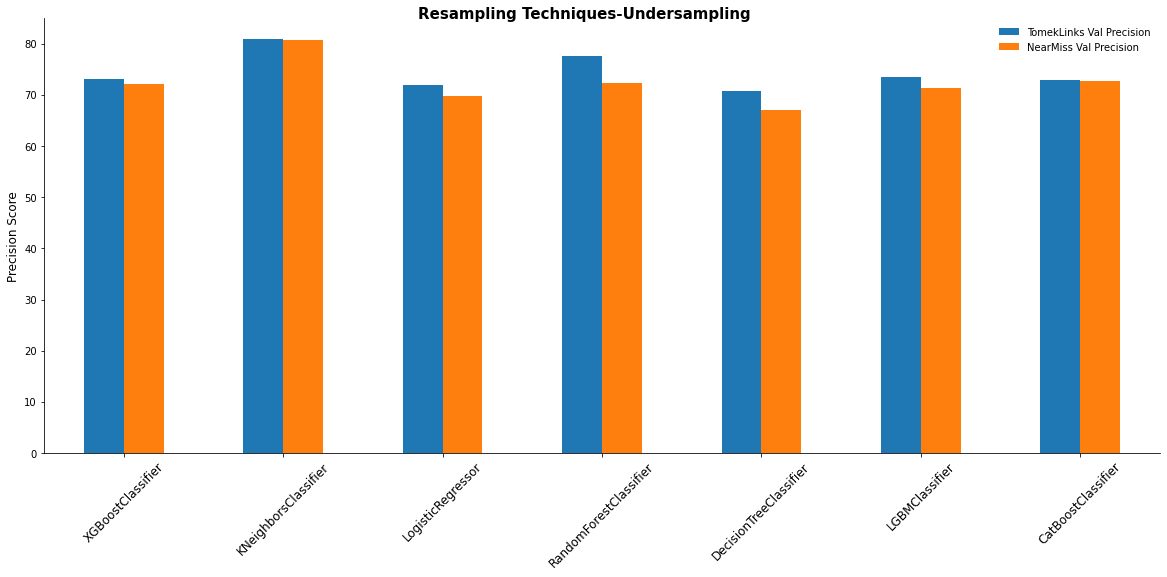

time: 172 ms (started: 2022-11-30 19:29:56 +08:00)


In [39]:
ps_under = pd.DataFrame(index=models_dict.keys())
ps_under['NoResampling Val Precision'] = auto_run[1]['Val Precision']
ps_under['TomekLinks Val Precision'] = outputs_u[0]['Val Precision']
ps_under['NearMiss Val Precision'] = outputs_u[1]['Val Precision']

fig, ax = plt.subplots(figsize=(20, 8))
ps_under.plot.bar(ax=ax)
ax.set_ylabel('Precision Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Undersampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

<div><span style="background-color: #ff0257; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFAF0; font-size: 18px; font-weight: bold">Grid-Search and Randomized Search Cross Validation </span></div>

#### Hypertuning

[Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [Randomized Search Cross Validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) are commonly used to hypertune models across multiple parameters

In [20]:
def train_cb(X, y, metric, res_t=None, hypertune=False, resample=False):
    """Hypertune"""
    params = {'n_estimators': [50, 100, 150, 200],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth': list(range(3, 20))
              }
    new_params = {'catbosstclassifier__' +
                  key: params[key] for key in params}

    skf = StratifiedKFold(n_splits=5)
    if resample is True:
        imba_pipeline = make_pipeline(MinMaxScaler(),
                                      res_t,
                                      ctb.CatBoostClassifier(#task_type="GPU",
                                                thread_count=-1,logging_level='Silent'))
    else:
        imba_pipeline = make_pipeline(MinMaxScaler(),
                                      ctb.CatBoostClassifier(#task_type="GPU",
                                                thread_count=-1,logging_level='Silent'))

    if hypertune is True:
        clf = GridSearchCV(imba_pipeline, param_grid=new_params,
                           cv=skf, scoring=metric, return_train_score=True,
                          verbose=10, n_jobs=-1)
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        model = clf.best_estimator_.fit(X, y)
        return ['Cat Boost', np.mean(clf.cv_results_['mean_train_score']),
                clf.best_score_, 'Best parameters = {0}'.format(
                    clf.best_params_),
                run_time, model]
    else:
        clf = imba_pipeline
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        cv_scores = cross_validate(estimator=clf, X=X, y=y,
                                   scoring=metric, cv=skf, n_jobs=-1,
                                   return_train_score=True)

        return ['Cat Boost', np.mean(cv_scores['train_score']),
                np.mean(cv_scores['test_score']), run_time, clf]

time: 0 ns (started: 2022-11-28 14:00:04 +08:00)


In [21]:
start_time = time.time()
rf_tmk_prec = train_cb(X_trainval, y_trainval, 'precision', NearMiss(),
                       hypertune=False, resample=False)
start_time = time.time()
rf_tmk_acc = train_cb(X_trainval, y_trainval, 'accuracy', NearMiss(),
                      hypertune=False, resample=False)

time: 1min 32s (started: 2022-11-28 14:00:05 +08:00)


In [22]:
cols = ['', 'Train Accuracy', 'Val Accuracy',
        'Train Precision', 'Val Precision']
hyper = pd.DataFrame(columns=cols)
hyper.loc[0] = [rf_tmk_prec[0],
                np.round(rf_tmk_acc[1]*100, 6),
                np.round(rf_tmk_acc[2]*100, 6),
                np.round(rf_tmk_prec[1]*100, 6),
                np.round(rf_tmk_prec[2]*100, 6)]
hyper2 = pd.DataFrame(columns=cols)
hyper2.loc[0] = [rf_tmk_prec[0],
                 '{:.2f}%'.format(np.round(rf_tmk_acc[1]*100, 2)),
                 '{:.2f}%'.format(np.round(rf_tmk_acc[2]*100, 2)),
                 '{:.2f}%'.format(np.round(rf_tmk_prec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(rf_tmk_prec[2]*100, 2))]
hyper2.style.hide_index()

,Train Accuracy,Val Accuracy,Train Precision,Val Precision
Cat Boost,74.04%,70.09%,74.13%,71.74%


time: 16 ms (started: 2022-11-28 14:02:26 +08:00)


In [23]:
rf_tmk_prec

['Cat Boost',
 0.7412949729685208,
 0.7174173736334654,
 10.826828479766846,
 Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                 ('catboostclassifier',
                  <catboost.core.CatBoostClassifier object at 0x0000018A89A31D60>)])]

time: 0 ns (started: 2022-11-28 14:02:28 +08:00)


In [24]:
# re-fitting for the holdout
rh = rf_tmk_prec[-1]
rh.fit(X_trainval, y_trainval)
y_preds = rh.predict(X_holdout)
rh_holdout_score = precision_score(y_holdout, y_preds)

time: 10.7 s (started: 2022-11-28 14:02:37 +08:00)


In [25]:
rh_holdout_score

0.7182293762575452

time: 16 ms (started: 2022-11-28 14:02:51 +08:00)


#### Base-case

In [ ]:
# # cross-validation
# base_var = train_rf(X_trainval, y_trainval, 'recall', hypertune=False, resample=False)

# # re-fitting for the holdout
# base_model = base_var[-1]

base_model.fit(X_trainval, y_trainval)
y_preds = base_model.predict(X_holdout)
holdout_score = recall_score(y_holdout, y_preds)

In [ ]:
cols = ['Method', 'Train Recall', 'Val Recall', 'Holdout Recall']
summary = pd.DataFrame(columns=cols)
summary.loc[0] = ['No Resampling',
                 '{:.2f}%'.format(np.round(base_var[1]*100, 2)),
                 '{:.2f}%'.format(np.round(base_var[2]*100, 2)),
                 '{:.2f}%'.format(np.round(holdout_score*100, 2))]
summary.loc[3] = ['Resampling x Hypertune',
                 '{:.2f}%'.format(np.round(rf_tmk_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(rf_tmk_rec[2]*100, 2)),
                 '{:.2f}%'.format(np.round(rh_holdout_score*100, 2))]
summary.style.hide_index()

In [ ]:
import pickle
output = open('pickles/gbc_hypertuned.pkl', 'wb')
pickle.dump(rh, output)
output.close()


#### Manual Base-case

##### Catboost

In [193]:
spec_model = {"model":
    ctb.CatBoostClassifier(#task_type="GPU",
                       thread_count=-1,logging_level='Silent'
                        #,depth= 15, n_estimators=50)
    )}



#CatBoostRegressor(iterations=300, learning_rate=0.1, random_seed=123)
#TomekLinks()
# var = auto_ml(X_trainval, y_trainval, spec_model, scaler=MinMaxScaler(),
#                 cv=StratifiedKFold(n_splits=5), res_t=TomekLinks())

var = auto_ml(X_trainval, y_trainval, spec_model, scaler=MinMaxScaler(),
                cv=StratifiedKFold(n_splits=5),res_t=None)

model=var[2]
model.fit(X_trainval, y_trainval)
#y_preds =model.predict(X_holdout)


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

time: 37.7 s (started: 2022-11-30 21:48:19 +08:00)


In [195]:
y_preds = (model.predict_proba(X_holdout)[:,1] >= 0.5).astype(bool)
a_holdout_score = accuracy_score(y_holdout, y_preds)
p_holdout_score = precision_score(y_holdout, y_preds)
r_holdout_score = recall_score(y_holdout, y_preds)
f1_holdout_score = f1_score(y_holdout, y_preds)

print("precision_holdout,","recall_holdout,", "f1_holdout","accuracy")
p_holdout_score,r_holdout_score,f1_holdout_score,a_holdout_score

precision_holdout, recall_holdout, f1_holdout accuracy


(0.7142857142857143,
 0.7777777777777778,
 0.7446808510638298,
 0.6883116883116883)

time: 16 ms (started: 2022-11-30 21:49:01 +08:00)


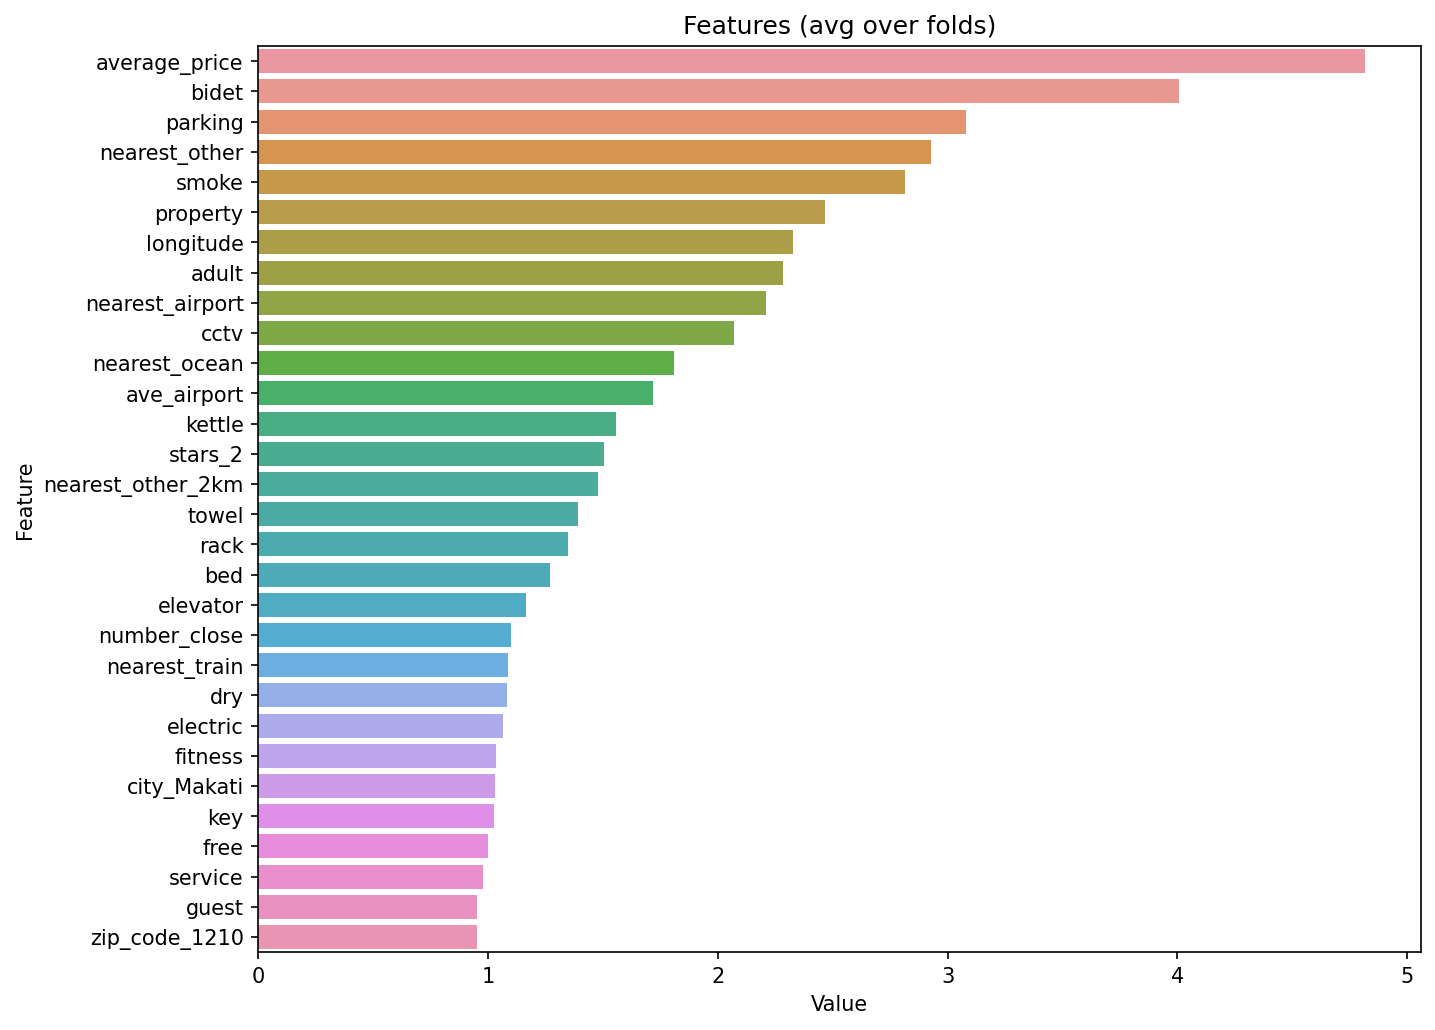

time: 282 ms (started: 2022-11-30 20:18:04 +08:00)


In [129]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_trainval.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 8), dpi=150)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(30))
#sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[-50:-30])
plt.title('Features (avg over folds)')
#plt.tight_layout()
plt.show()

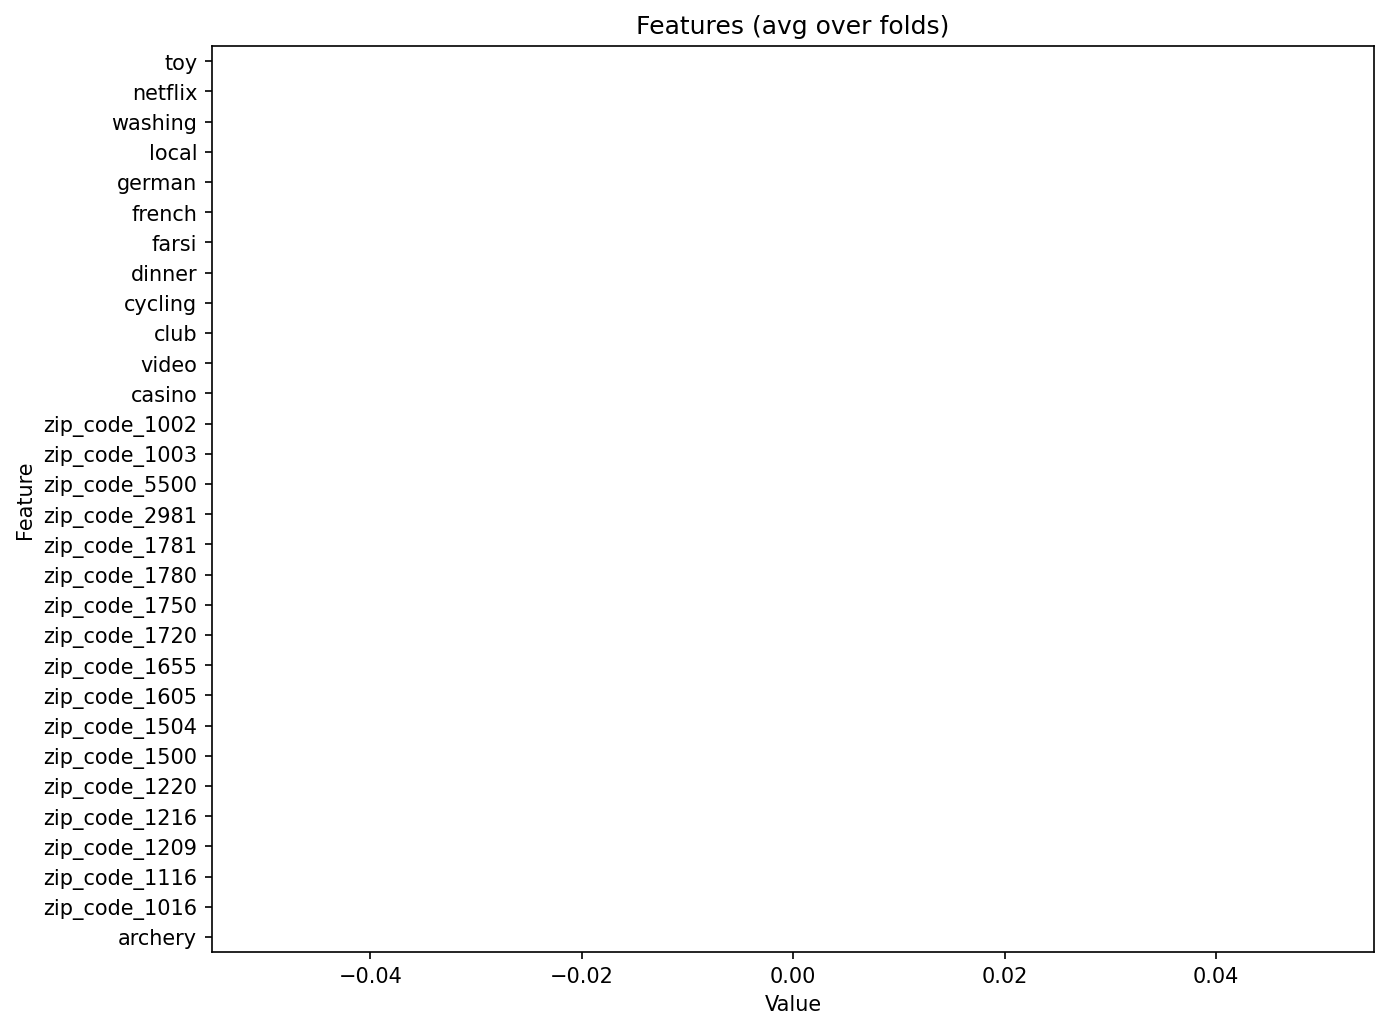

time: 297 ms (started: 2022-11-30 20:18:10 +08:00)


In [130]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_trainval.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 8), dpi=150)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).tail(30))
#sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[-50:-30])
plt.title('Features (avg over folds)')
#plt.tight_layout()
plt.show()

60

77

'Took 77.92% of total trades'

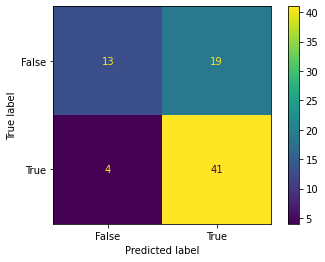

time: 141 ms (started: 2022-11-30 20:18:17 +08:00)


In [131]:

display(sum(y_preds),len(y_holdout))
display("Took {:0.2f}% of total trades". format(sum(y_preds)/len(y_holdout)*100))
confusion_matrix = metrics.confusion_matrix(y_holdout, y_preds)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

##### Lightgbm

In [120]:
# model= LGBMClassifier(n_jobs=-1)

# parameters = {'max_depth'         : [5,8,10],
#               'n_estimators' :  [10,20,30],
#              #'learning_rate' : [0.1,0.2,0.3,0.4],
#               #'iterations'    : [3,5,10]
              
#              }

# metric="precision"
# gridsearch(model,parameters,metric)

time: 0 ns (started: 2022-11-28 16:27:17 +08:00)


In [203]:
#Tomeklinks-70.31%

#spec_model = {"model":LGBMClassifier(max_depth=5, n_estimators=10,n_jobs=-1)}
spec_model = {"model":LGBMClassifier(n_jobs=-1)}

var = auto_ml(X_trainval, y_trainval, spec_model, scaler=MinMaxScaler(),
                cv=StratifiedKFold(n_splits=5), res_t=None)

model=var[2]

model.fit(X_trainval, y_trainval)


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

LGBMClassifier()

time: 563 ms (started: 2022-11-30 21:49:55 +08:00)


In [197]:
y_preds = (model.predict_proba(X_holdout)[:,1] >= 0.5).astype(bool)
a_holdout_score = accuracy_score(y_holdout, y_preds)
p_holdout_score = precision_score(y_holdout, y_preds)
r_holdout_score = recall_score(y_holdout, y_preds)
f1_holdout_score = f1_score(y_holdout, y_preds)

print("precision_holdout,","recall_holdout,", "f1_holdout","accuracy")
p_holdout_score,r_holdout_score,f1_holdout_score,a_holdout_score

precision_holdout, recall_holdout, f1_holdout accuracy


(0.7608695652173914,
 0.7777777777777778,
 0.7692307692307693,
 0.7272727272727273)

time: 16 ms (started: 2022-11-30 21:49:09 +08:00)


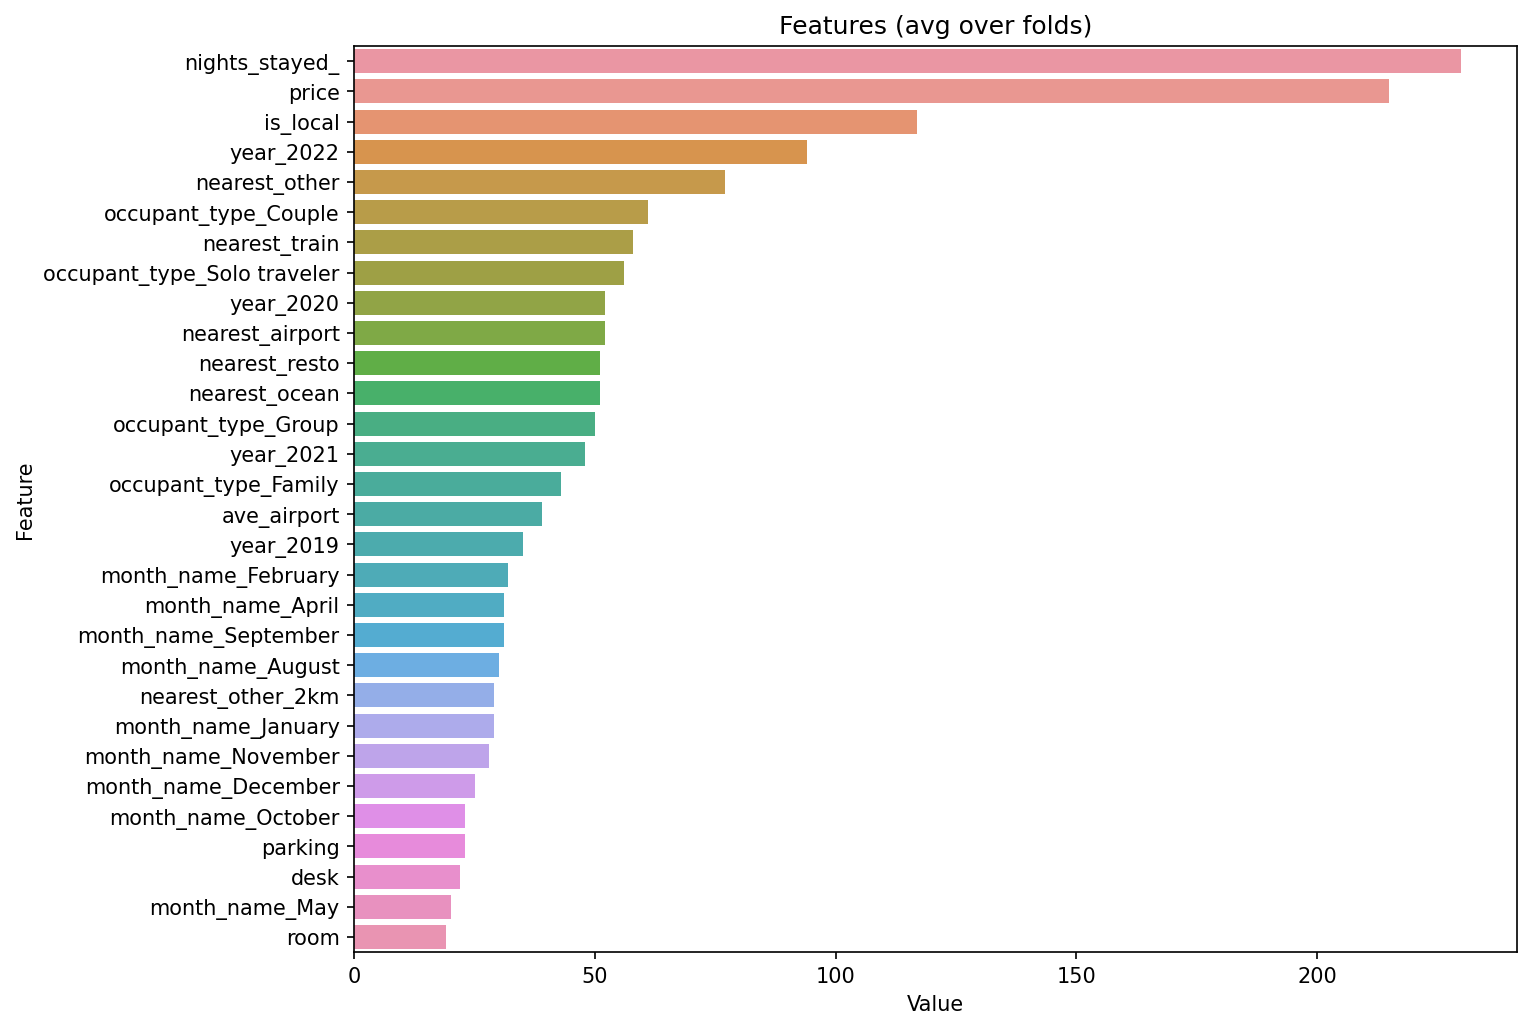

time: 344 ms (started: 2022-11-30 18:44:21 +08:00)


In [10]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_trainval.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 8), dpi=150)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(30))
#sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[-50:-30])
plt.title('Features (avg over folds)')
#plt.tight_layout()
plt.show()

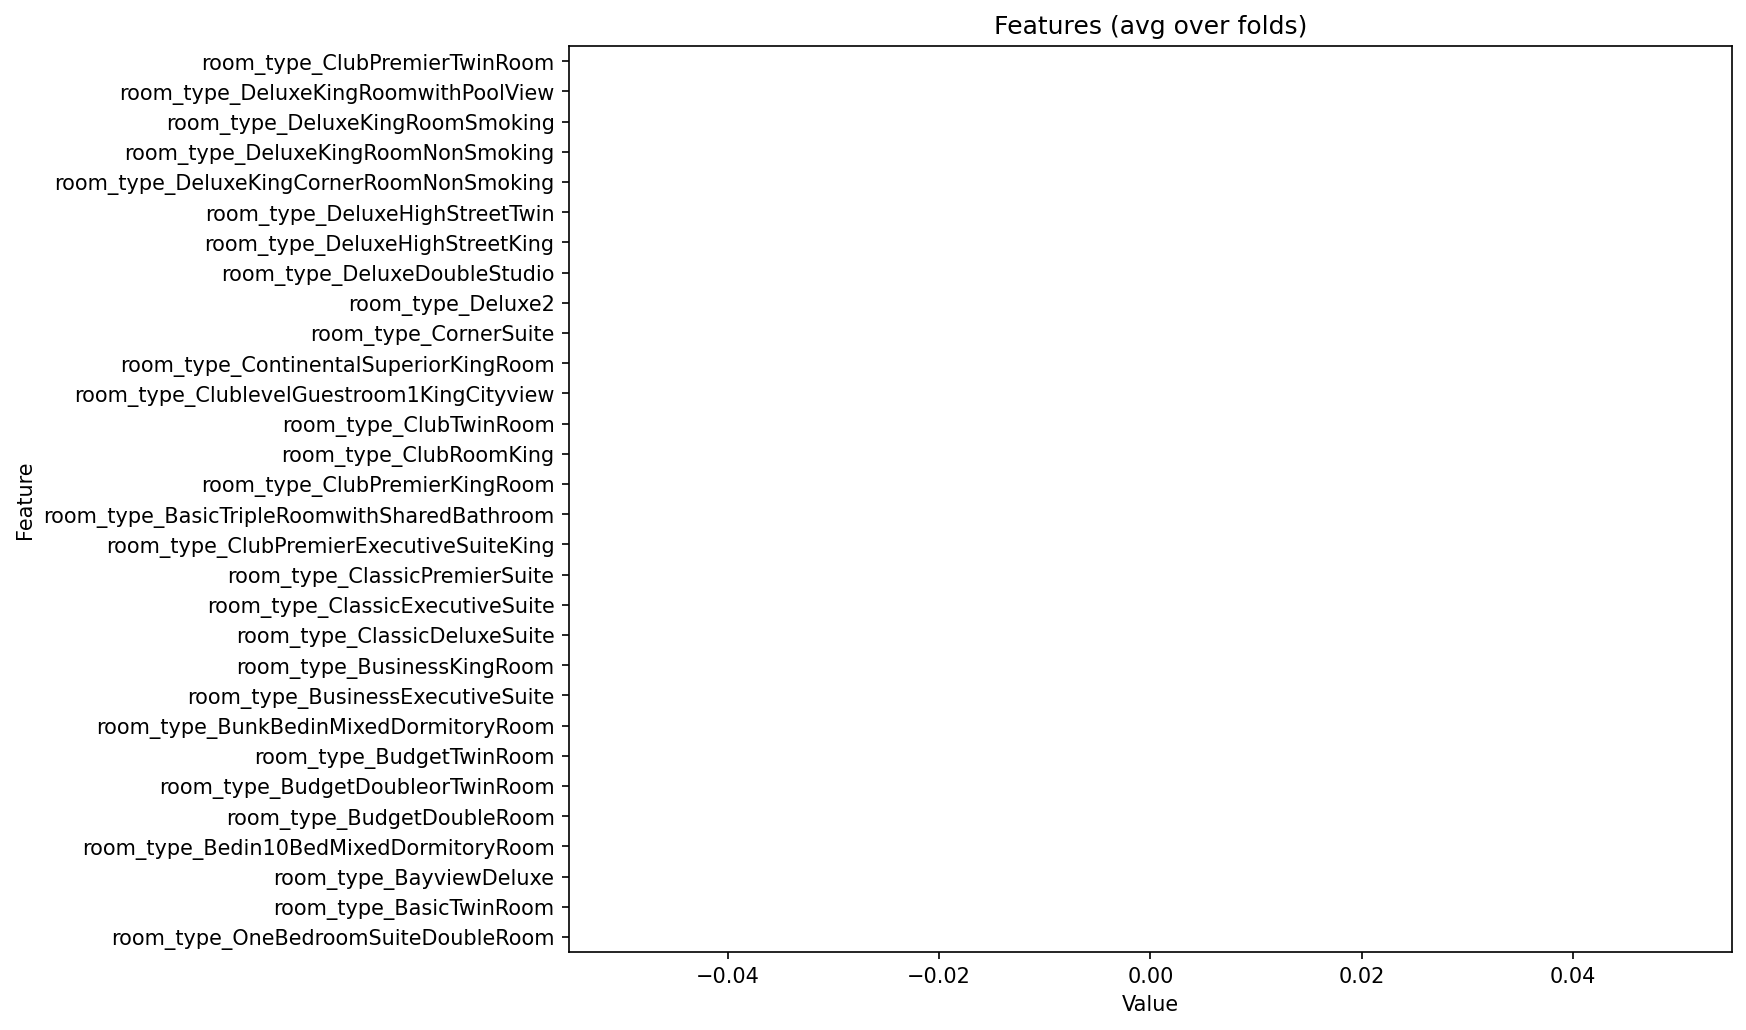

time: 375 ms (started: 2022-11-28 14:37:47 +08:00)


In [74]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_trainval.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 8), dpi=150)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).tail(30))
#sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[-50:-30])
plt.title('Features (avg over folds)')
#plt.tight_layout()
plt.show()

3292

14463

'Took 22.76% of total trades'

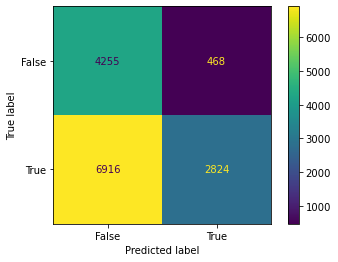

time: 156 ms (started: 2022-11-29 15:33:44 +08:00)


In [49]:
display(sum(y_preds),len(y_holdout))
display("Took {:0.2f}% of total trades". format(sum(y_preds)/len(y_holdout)*100))
confusion_matrix = metrics.confusion_matrix(y_holdout, y_preds)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

##### XGBoost

In [198]:
#spec_model = {"model":LGBMClassifier(max_depth=5, n_estimators=10,n_jobs=-1)}
spec_model = {"model":xgb.XGBClassifier(n_jobs=-1,tree_method="gpu_hist")}

var = auto_ml(X_trainval, y_trainval, spec_model, scaler=MinMaxScaler(),
                cv=StratifiedKFold(n_splits=5), res_t=None)

model=var[2]

model.fit(X_trainval, y_trainval)


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

time: 2.75 s (started: 2022-11-30 21:49:19 +08:00)


In [199]:
y_preds = (model.predict_proba(X_holdout)[:,1] >= 0.5).astype(bool)
a_holdout_score = accuracy_score(y_holdout, y_preds)
p_holdout_score = precision_score(y_holdout, y_preds)
r_holdout_score = recall_score(y_holdout, y_preds)
f1_holdout_score = f1_score(y_holdout, y_preds)

print("precision_holdout,","recall_holdout,", "f1_holdout","accuracy")
p_holdout_score,r_holdout_score,f1_holdout_score,a_holdout_score

precision_holdout, recall_holdout, f1_holdout accuracy


(0.75, 0.8, 0.7741935483870969, 0.7272727272727273)

time: 31 ms (started: 2022-11-30 21:49:22 +08:00)


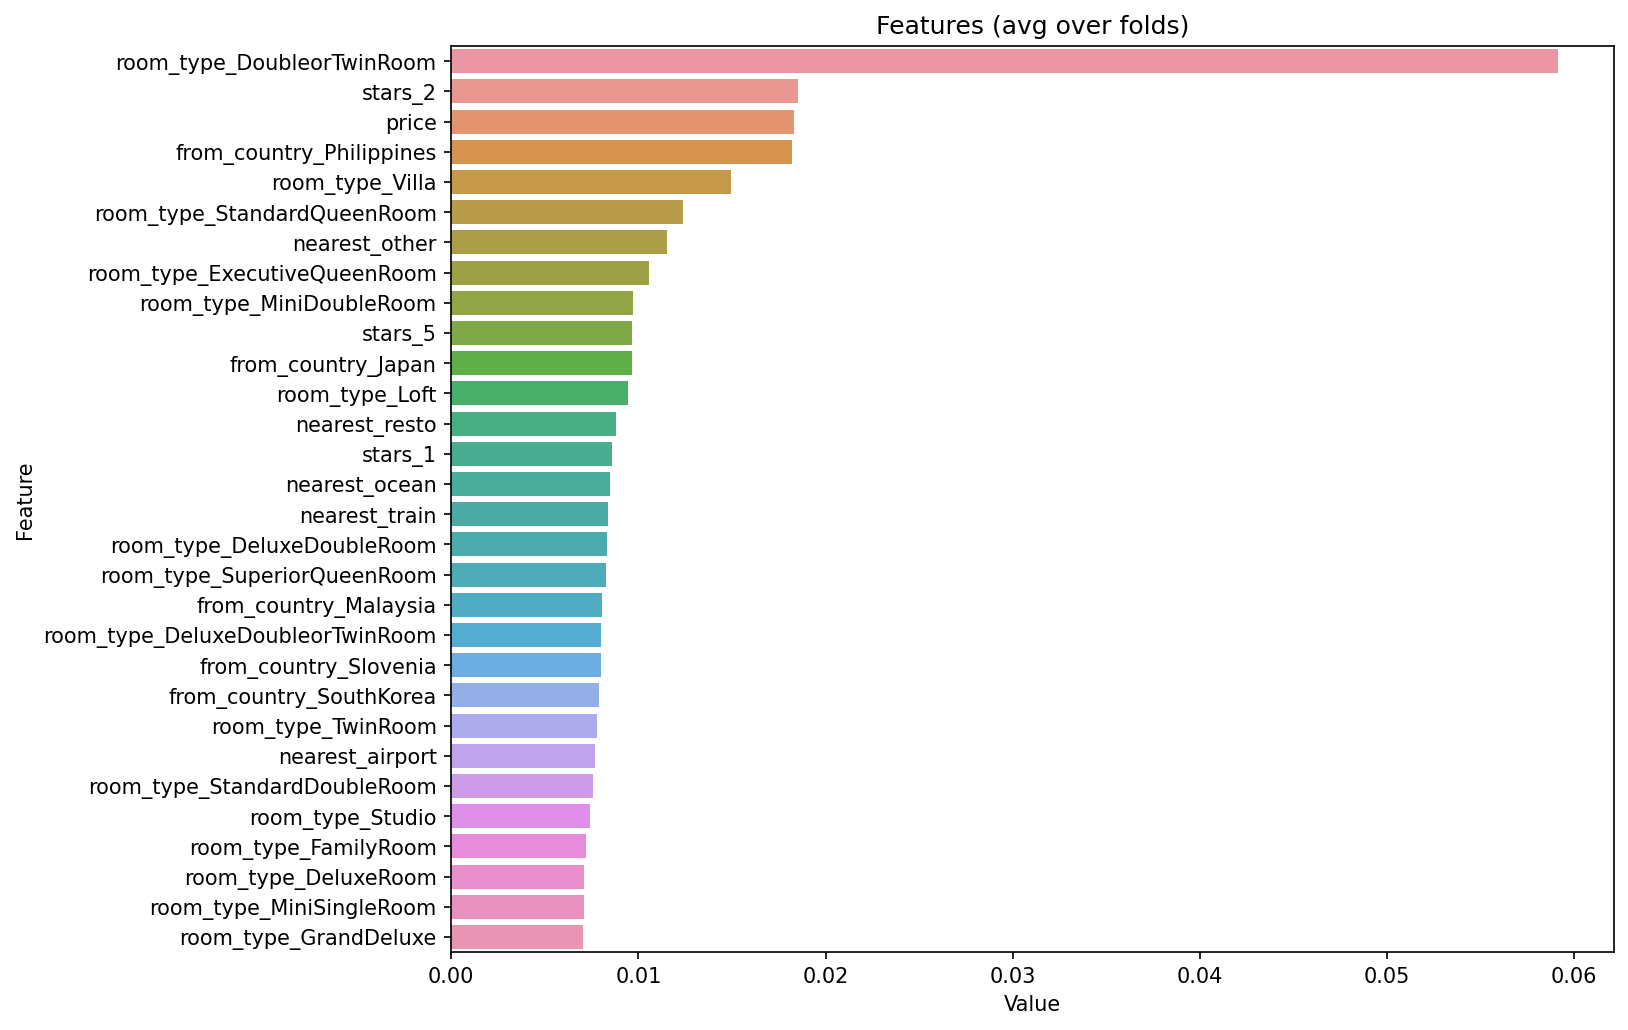

time: 422 ms (started: 2022-11-28 14:45:24 +08:00)


In [85]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_trainval.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 8), dpi=150)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(30))
#sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[-50:-30])
plt.title('Features (avg over folds)')
#plt.tight_layout()
plt.show()

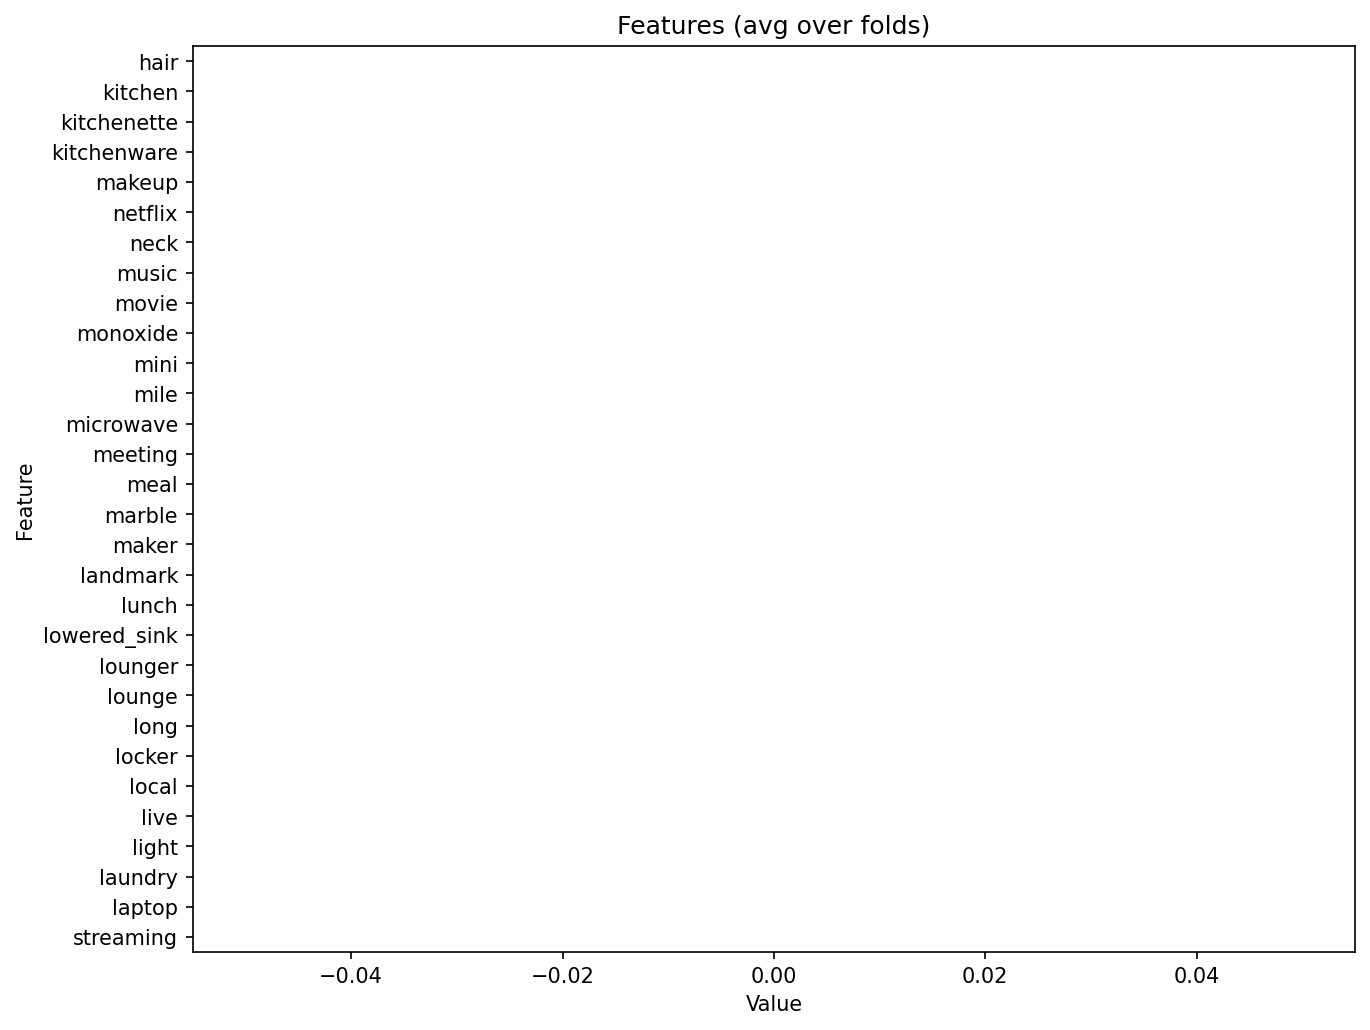

time: 297 ms (started: 2022-11-30 20:01:19 +08:00)


In [83]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_trainval.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 8), dpi=150)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).tail(30))
#sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[-50:-30])
plt.title('Features (avg over folds)')
#plt.tight_layout()
plt.show()

14199

14417

'Took 98.49% of total trades'

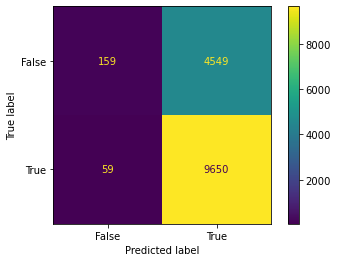

time: 188 ms (started: 2022-11-28 14:38:18 +08:00)


In [75]:
display(sum(y_preds),len(y_holdout))
display("Took {:0.2f}% of total trades". format(sum(y_preds)/len(y_holdout)*100))
confusion_matrix = metrics.confusion_matrix(y_holdout, y_preds)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

##### Random Forest

In [200]:
#spec_model = {"model":LGBMClassifier(max_depth=5, n_estimators=10,n_jobs=-1)}
spec_model = {"model": RandomForestClassifier(n_jobs=-1)}

var = auto_ml(X_trainval, y_trainval, spec_model, scaler=MinMaxScaler(),
                cv=StratifiedKFold(n_splits=5), res_t=None)

model=var[2]

model.fit(X_trainval, y_trainval)


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

RandomForestClassifier(n_jobs=-1)

time: 1.17 s (started: 2022-11-30 21:49:30 +08:00)


In [201]:
y_preds = (model.predict_proba(X_holdout)[:,1] >= 0.5).astype(bool)
a_holdout_score = accuracy_score(y_holdout, y_preds)
p_holdout_score = precision_score(y_holdout, y_preds)
r_holdout_score = recall_score(y_holdout, y_preds)
f1_holdout_score = f1_score(y_holdout, y_preds)

print("precision_holdout,","recall_holdout,", "f1_holdout","accuracy")
p_holdout_score,r_holdout_score,f1_holdout_score,a_holdout_score

precision_holdout, recall_holdout, f1_holdout accuracy


(0.7115384615384616,
 0.8222222222222222,
 0.7628865979381444,
 0.7012987012987013)

time: 32 ms (started: 2022-11-30 21:49:31 +08:00)


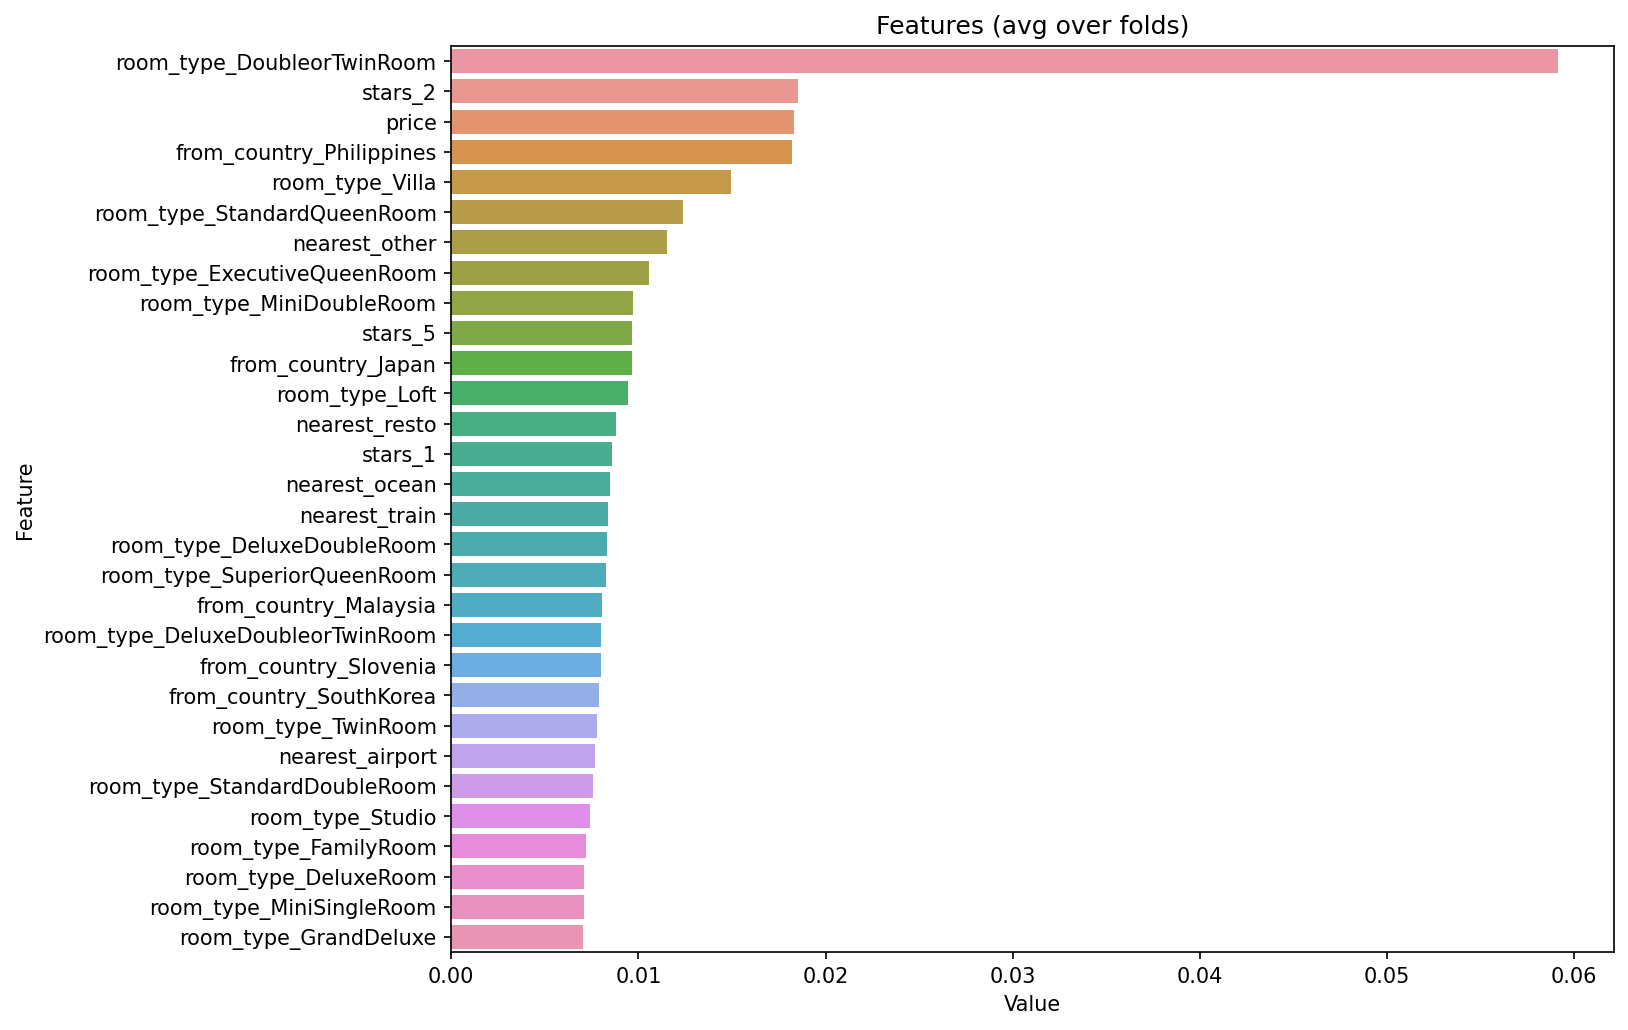

time: 422 ms (started: 2022-11-28 14:45:24 +08:00)


In [85]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_trainval.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 8), dpi=150)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(30))
#sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[-50:-30])
plt.title('Features (avg over folds)')
#plt.tight_layout()
plt.show()

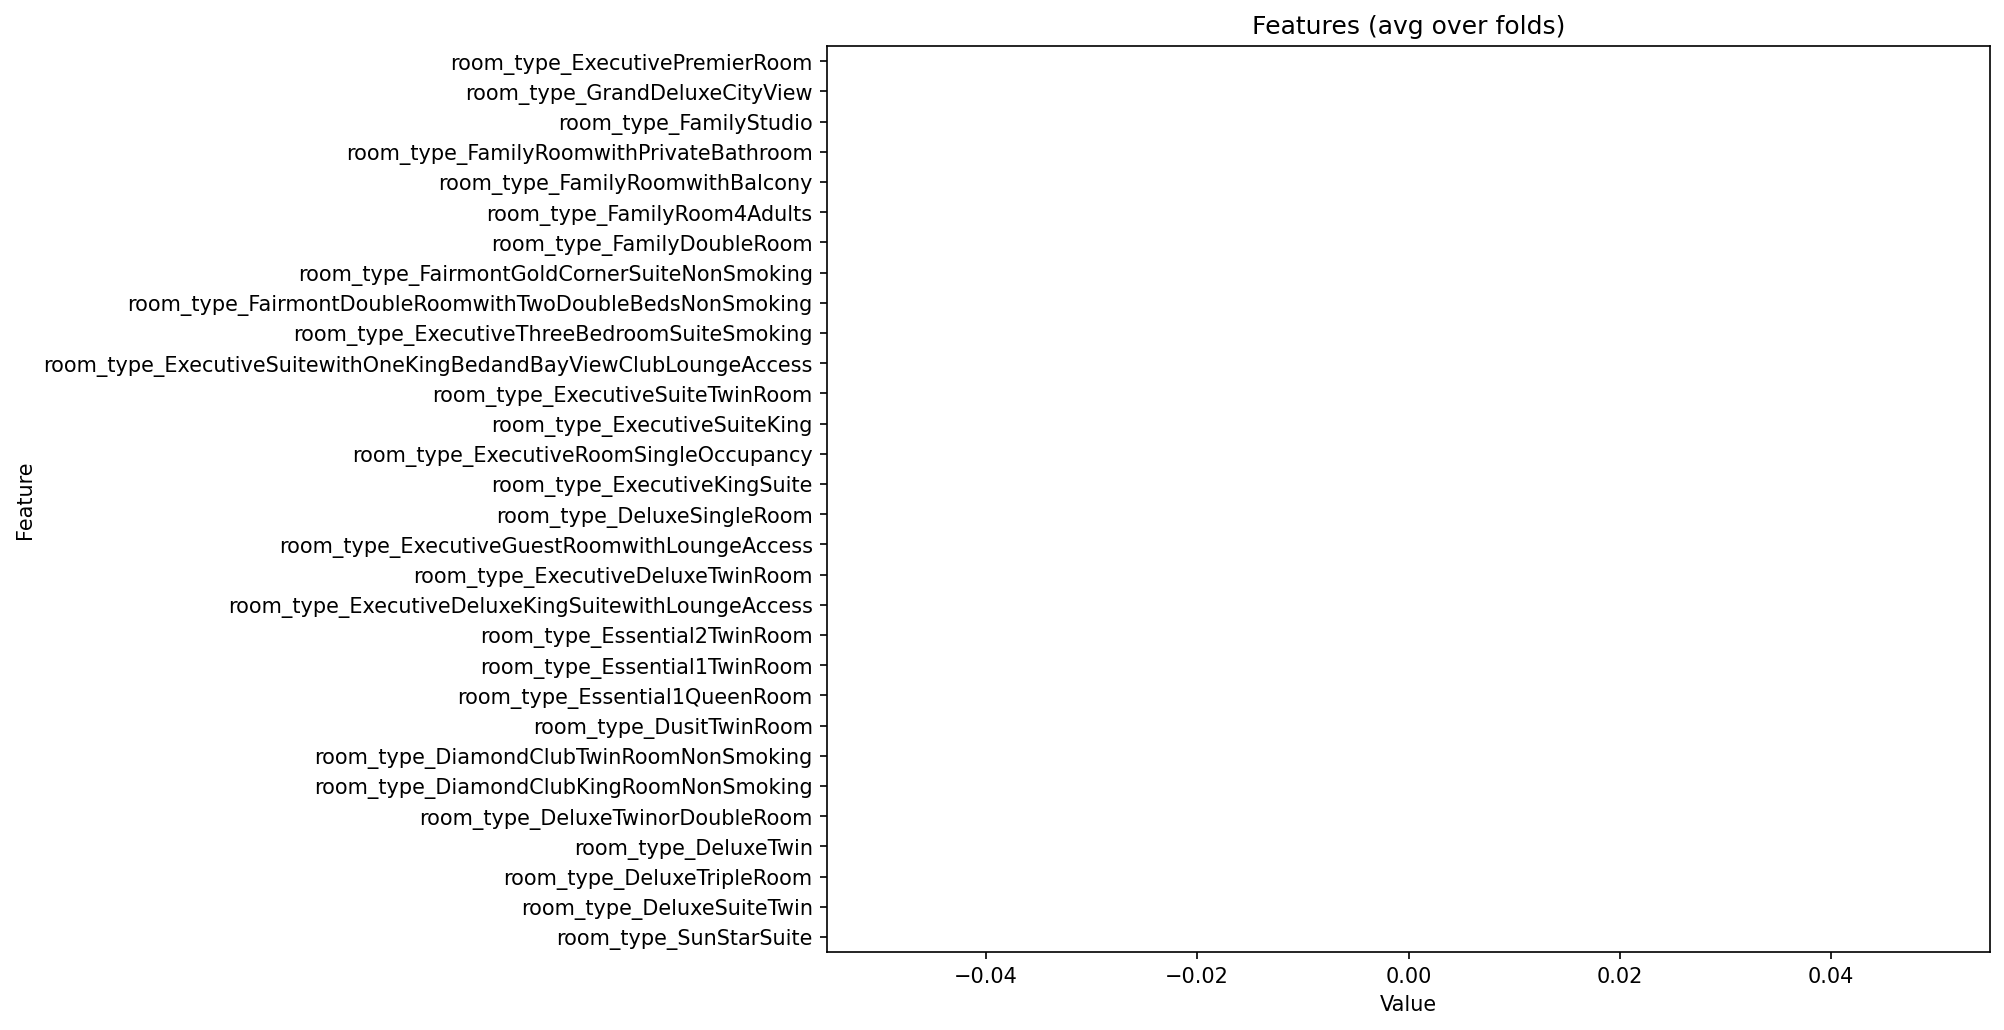

time: 391 ms (started: 2022-11-28 14:45:28 +08:00)


In [86]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_trainval.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 8), dpi=150)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).tail(30))
#sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[-50:-30])
plt.title('Features (avg over folds)')
#plt.tight_layout()
plt.show()

14199

14417

'Took 98.49% of total trades'

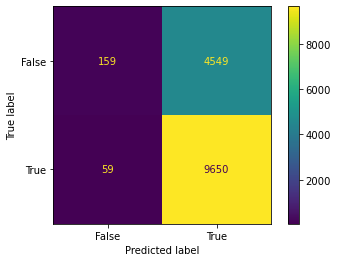

time: 188 ms (started: 2022-11-28 14:38:18 +08:00)


In [75]:
display(sum(y_preds),len(y_holdout))
display("Took {:0.2f}% of total trades". format(sum(y_preds)/len(y_holdout)*100))
confusion_matrix = metrics.confusion_matrix(y_holdout, y_preds)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

##### KNN

In [202]:
spec_model = {"model": KNeighborsClassifier(n_neighbors=3),}

var = auto_ml(X_trainval, y_trainval, spec_model, scaler=MinMaxScaler(),
                cv=StratifiedKFold(n_splits=5), res_t=None)

model=var[2]

model.fit(X_trainval, y_trainval)
y_preds = (model.predict_proba(X_holdout)[:,1] >= 0.5).astype(bool)
p_holdout_score = precision_score(y_holdout, y_preds)
r_holdout_score = recall_score(y_holdout, y_preds)
f1_holdout_score = f1_score(y_holdout, y_preds)

print("precision_holdout,","recall_holdout,", "f1_holdout")
p_holdout_score,r_holdout_score,f1_holdout_score

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

precision_holdout, recall_holdout, f1_holdout


(0.6444444444444445, 0.6444444444444445, 0.6444444444444445)

time: 281 ms (started: 2022-11-30 21:49:42 +08:00)


2258

3436

'Took 65.72% of total trades'

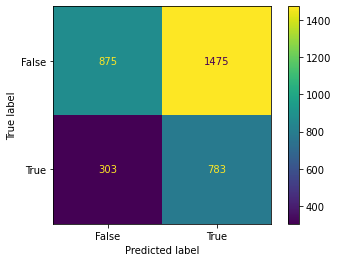

time: 484 ms (started: 2022-11-08 22:50:07 +08:00)


In [68]:
import sklearn.metrics as metrics
display(sum(y_preds),len(y_holdout))
display("Took {:0.2f}% of total trades". format(sum(y_preds)/len(y_holdout)*100))
confusion_matrix = metrics.confusion_matrix(y_holdout, y_preds)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

# Interpretability

In [204]:
model

LGBMClassifier()

time: 16 ms (started: 2022-11-30 21:49:59 +08:00)


In [205]:
explainer = shap.TreeExplainer(model, feature_names=X_holdout.columns)
shap_values_test = explainer.shap_values(X_holdout)

time: 32 ms (started: 2022-11-30 21:50:01 +08:00)


In [184]:
# x_train_summary = shap.kmeans(X_trainval, 10)
# #x_train_summary = shap.kmeans(X_holdout, 10)
# explainer = shap.KernelExplainer(model.predict_proba, x_train_summary)
# shap_values_test = explainer.shap_values(X_holdout,\
#                                 nsamples=200, l1_reg="num_features(20)")

time: 0 ns (started: 2022-11-30 20:33:09 +08:00)


In [206]:
import pickle

#change explainer to rh/shap values
output = open('data/models/explainer.pkl', 'wb')
pickle.dump(explainer, output)
output.close()


output = open('data/models/best_model_lightgbm.pkl', 'wb')
pickle.dump(model, output)
output.close()


output = open('data/models/shap_values.pkl', 'wb')
pickle.dump(shap_values_test, output)
output.close()


#------------------------------------------------------

# (X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
#                                                                   random_state=11, test_size=0.25,
#                                                                   stratify=y)

output = open('data/models/X_trainval.pkl', 'wb')
pickle.dump(X_trainval, output)
output.close()

output = open('data/models/X_holdout.pkl', 'wb')
pickle.dump(X_holdout, output)
output.close()

output = open('data/models/y_trainval.pkl', 'wb')
pickle.dump(y_trainval, output)
output.close()

output = open('data/models/y_holdout.pkl', 'wb')
pickle.dump(y_holdout, output)
output.close()


time: 15 ms (started: 2022-11-30 21:50:02 +08:00)
